In [1]:
from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
# from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
# from reproject import reproject_interp

import glob
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


#switches for the three different parts of this code
switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
switch1b = 'on' #regridding...
switch2 = 'on' #solving equations
switch3 = 'on' #plotting / graphics of solutions


if switch1 == 'on':

    # In[4]:

    # #finding the path to every fits images in a directory
    def im_name_finder(path, file_type):
        #Using glob (it's a unix command similar to ls)
        #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
        #if needed, some example code is commented towards the latter half of this code that could help make an alternative
        all_names = glob.glob(path, recursive=True)

        #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
        #using s.lower() include uppercase names
        im_names = [s for s in all_names if 'fit' in s.lower()]

        return im_names


    # In[5]:

    '''now convolve my image with a PSF of the image we're projecting ONTO
    an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
    that is the st dev of the Gaussian is about the st dev is about = lambda/D
    a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

    Notes:
    FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

    what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
    so it's 1.2 not 1.22 times lambda/D

    D is 85 cm for spitzer
    D is 2.4 m for hubble
    '''

    def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern, fwhm=None):
        #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

        #reading in excel file of wavelengths...right now needs to be in same directory as this code
        #first col is a substring of the fits image file name, the second col is the wavelengths in microns
        df = pd.read_excel('../../../imglams.xlsx')
        cols = df.columns
        cols_str = [str(i) for i in df[cols[0]]]
        #some test cases I was using
        
        if kern == 'epsf_fwhm':
            kernel = Gaussian2DKernel(fwhm)
        
        #gaussian kernel
        if kern == 'gauss':
            #this finds the loc in the excel file where the image substring matches our image name
            #it then finds the wavelength value corresponding to that loc
            lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns
            
            #finding angular resolution...the FWHM of our Gaussian PSF
            res = 1.2 * lam / D         #resolution in radians
#             print('Angular Res (rads): ', res, ' File Name to Convolve With: ', low_res_name, ' Lambda: ', lam)
            res = res / hdu_pix_torad        #so converting to pixels
#             print('Angular Res (pixels): ', res, ' File Name to Convolve With: ', low_res_name, ' Lambda: ', lam)

            #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
            kernel = Gaussian2DKernel(res)
        
        #box kernel
        if kern == 'box':
            kernel = Box2DKernel(16.)

        hdu_conv = convolve(hdu_dat, kernel)
        return hdu_conv


    # In[21]:
    
    
    #setting up a new fits file to be saved and viewed in DS9
    #primarily to save the image we reprojected, but can also be used to save the convolved images
    def fits_saver(array, wcs_header, name, save_path):
        '''
        array is a 2d array of data - could be from reprojecting one image onto another or from convolution
        wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
        name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
        save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
        '''

        #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
        hdu_new = fits.PrimaryHDU(array, header=wcs_header)
        hdul = fits.HDUList([hdu_new])

        #saving the file
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)

        return (save_path+new_filename)
    
    

    #EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
    #set your path to some directory with images (the images can be in subdirectories)
    #using ** will grab all files even in subdirectories...WARNING this will take longer

    # In[28]:
    #this time setting up the file names by hand since I've found that easier...
    #order: halpha or .656 mic, 0.672 mic, 1.26, 1.28, 1.64
    files_units = ['../../../../ngc1333_fits/unregridded/656_image.fits', 
                   '../../../../ngc1333_fits/unregridded/0301_flt.fits', 
                   '../../../../ngc1333_fits/unregridded/0501_flt.fits', 
                   '../../../../ngc1333_fits/126build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/128build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/164build_shift_2_drz.fits']
    hdu_list_units = [fits.open(i) for i in files_units]
    files_data = ['../../../../ngc1333_fits/656_hareproject_shifted_up5_left3.fits', 
                  '../../../../ngc1333_fits/0301_oIreproject2.fits', 
                  '../../../../ngc1333_fits/672_sIIreproject.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_126_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_128_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_164_aligned.fits']
    hdu_list = [fits.open(i) for i in files_data]

    hdu_pix_list = []
    hdu_pixtorad_list = []
    hdu_fnu_list = []
    hdu_flam_list = []
    hdu_bw_list = []
    hdu_data_list = []
    hdu_header_list = []
    throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?


    #I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
    #the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
    #I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
    count = 0
    for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
        if count <= 2: # == 0 or count == 2:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
#             print('D001SCAL: ', hdu_pix_list[count], ' D001SCAL/206265: ', hdu_pixtorad_list[count])
            # hdu_fnu_list.append(hdu_units[1].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[1].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[1].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        else:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
#             print('D001SCAL: ', hdu_pix_list[count], ' D001SCAL/206265: ', hdu_pixtorad_list[count])
            # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        count += 1


    #can update later...but basically the sulfur II image header isn't avail...
    #header info taken from https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration/quad-filter-photometry
    #update: HAlpha etc uses https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf
    hdu_flam_list[0] = 1.6600e-17
    hdu_bw_list[0] = 41.77 #from Dan, in A
    hdu_flam_list[2] = 1.3699e-17
    hdu_bw_list[2] = 18.5

    print('loaded data!')



3.8.5
loaded data!


[['03h29m02.8902198504s' '+31d16m00.953186124s']
 ['03h29m02.1578803464s' '+31d16m11.433429732s']
 ['3h29m03.7578170808s' '+31d16m03.947525688s']]
[<Table length=1>
  MAIN_ID         RA           DEC      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                                     
   object       str13         str13     ...        object            int32      
----------- ------------- ------------- ... ------------------- ----------------
V* V512 Per 03 29 03.7578 +31 16 03.947 ... 2020yCat.1350....0G                1]


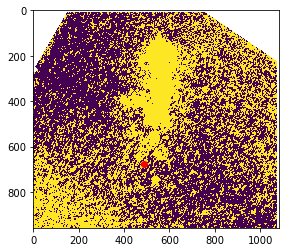

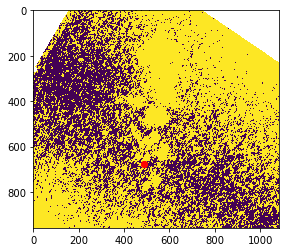

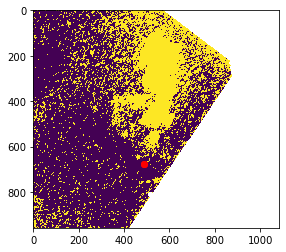

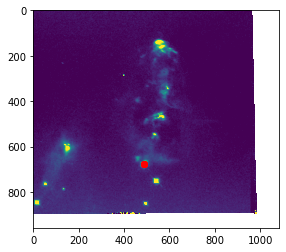

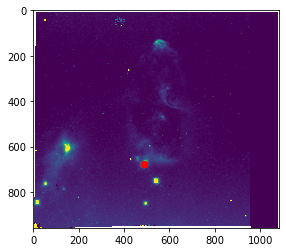

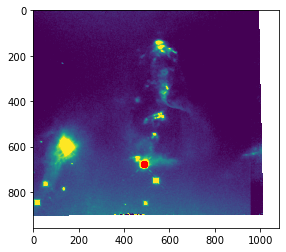

C:\Users\arubi\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\arubi\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\arubi\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

In [96]:
%matplotlib inline

#the goal of this cell is to refine object coordinates from some initial guesses using either 2MASS or GAIA

#taking star coords from text file
star_coords = np.genfromtxt('hh711_star_coords.txt', dtype=str)
print(star_coords)

#setting up query
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
import astropy.units as u

result_table = []
for i in [star_coords[2]]: #picking stars, trying to eliminate one...
    ra, dec = i
    result_table.append(Simbad.query_region(SkyCoord(ra+dec, frame='icrs'), radius='0.05s'))
print(result_table)

#defining psfs for original images...

#finally, make psfs for each star and then we determine the resolution from the PSFs
#can be done by fitting a gaussian (or other kernel) and normalizing so integral of psf is 1

#follow https://photutils.readthedocs.io/en/stable/epsf.html

#now, locate spots on the images
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm, ZScaleInterval, ImageNormalize
from astropy.table import Table
from astropy.wcs.utils import skycoord_to_pixel
from photutils.psf import extract_stars #use this to make star cutouts

file_start = ['conv_0301_oIreproject2', 'conv_hareproject_shifted_up5_left3', 'conv_672_sIIreproject', 'conv_126_aligned', 'conv_128_aligned', 'conv_164_aligned.fits', 'f_Fe', 'f_H']

nrows = 1
ncols = 1

img_size = 15
stars_list=[]

#this was made complicated bc you cannot directly go from skycoord to Table
stars_tbl = Table(names=('x', 'y'))
for i in range(len(hdu_data_list)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

    ra_dec_formatted = SkyCoord(result_table[0]['RA'][0] + ' ' + result_table[0]['DEC'][0], frame='icrs', unit=(u.hourangle, u.deg))
    pix = skycoord_to_pixel(ra_dec_formatted, WCS(hdu_header_list[i]))
    stars_tbl.add_row(pix)

    xstart =int(stars_tbl['x'][i]-img_size)
    xend = int(stars_tbl['x'][i]+img_size)
    ystart = int(stars_tbl['y'][i]-img_size)
    yend = int(stars_tbl['y'][i]+img_size)
    stars_list.append(hdu_data_list[i][ystart:yend, xstart:xend])

    norm = ImageNormalize(hdu_data_list[i][ystart:yend, xstart:xend], interval=ZScaleInterval())
    ax.imshow(hdu_data_list[i][ystart:yend, xstart:xend], norm=norm, origin='lower', cmap='viridis')

    plt.tight_layout()
    plt.savefig('hh7_11_checks/psfcutouts_orig/'+file_start[i]+'_psfcutout_orig.png')
    plt.close()

    plt.imshow(hdu_data_list[i], vmin=1e-18, vmax=1e-16)
    plt.scatter(stars_tbl['x'], stars_tbl['y'], color='red')
    plt.show()
    plt.close()
    

    
#attempting and failing to make an effective psf fitter

#increase maxiters to smooth more and decrease oversampling to avoid issues 
import scipy as sp
from scipy.signal import find_peaks, peak_widths, peak_prominences

fwhm_list = []

for i in range(len(stars_list)):
    norm = ImageNormalize(stars_list[i], interval=ZScaleInterval())
    plt.imshow(stars_list[i], norm=norm, origin='lower', cmap='viridis')
    plt.colorbar()
    plt.savefig('hh7_11_checks/EPSFs_orig/'+file_start[i]+'_EPSF_orig.png')
    plt.close()
    
        #https://photutils.readthedocs.io/en/stable/psf_matching.html could be inspiration
    #https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-12.pdf can see for more...

    #instead let's double check stackoverflow for now...seems complex
    #ultimately just trying epsf cross section, like in https://stackoverflow.com/questions/18920614/plot-cross-section-through-heat-map

    # Coordinates of the line we'd like to sample along
    line = [(0, 17), (29, 17)] #start/center, end/center

    # Convert the line to pixel/index coordinates
    x, y = np.arange(stars_list[i].shape[0]), np.arange(stars_list[i].shape[1])
    x_world, y_world = np.array(list(zip(*line)))
    col = stars_list[i].shape[1] * (x_world - x.min()) / x.ptp()
    row = stars_list[i].shape[0] * (y_world - y.min()) / y.ptp()

    # Interpolate the line at "num" points...
    num = int(img_size*4)
    row, col = [np.linspace(item[0], item[1], num) for item in [row, col]]

    # Plot...
    fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
#     fig.delaxes(axes[0,1])
    axes[1,0].imshow(stars_list[i], norm=norm, origin='lower', cmap='viridis')
#     axes[1,0].pcolormesh(x, y, stars_list[i], norm=norm)
    axes[1,0].plot(x_world, y_world, 'ro-')
    axes[1,0].plot(y_world, x_world, 'bo-')
    axes[1,0].axis('image')

    # Extract the values along the line, using cubic interpolation
    #horizontal cut
    cross_sec_hori = sp.ndimage.map_coordinates(stars_list[i], np.vstack((row, col)))
    axes[0,0].plot(np.arange(len(cross_sec_hori)), cross_sec_hori, color='r', marker='o')

    #vertical cut
    cross_sec_vert = sp.ndimage.map_coordinates(stars_list[i], np.vstack((col, row)))
    axes[1,1].plot(cross_sec_vert, np.arange(len(cross_sec_vert)), color='b', marker='o')

    #find all peaks
    peak_list_hori, _ = find_peaks(cross_sec_hori)
    peak_list_vert, _ = find_peaks(cross_sec_vert)
    
    #find largest peak, referring to ind of the list above
    peak_hori_ind = np.argmax([cross_sec_hori[i] for i in peak_list_hori]) 
    peak_vert_ind = np.argmax([cross_sec_vert[i] for i in peak_list_vert])
    
    #plotting to confirm peaks
    axes[0,0].scatter(np.arange(len(cross_sec_vert))[peak_list_hori[peak_hori_ind]], cross_sec_hori[peak_list_hori[peak_hori_ind]], marker='*', color='gold', s=500)
    axes[1,1].scatter(cross_sec_vert[peak_list_vert[peak_vert_ind]], np.arange(len(cross_sec_vert))[peak_list_vert[peak_vert_ind]], marker='*', color='gold', s=500)
   
    #use to find widths...also normalizing with the length of the array / step
    prominences_hori = peak_prominences(cross_sec_hori, [peak_list_hori[peak_hori_ind]])
    prominences_vert = peak_prominences(cross_sec_vert, [peak_list_vert[peak_vert_ind]])
    
    width_norm = num / img_size / 2.
    width_hori = peak_widths(cross_sec_hori, [peak_list_hori[peak_hori_ind]], prominence_data=prominences_hori, rel_height=0.5)[0] / width_norm
    width_vert = peak_widths(cross_sec_vert, [peak_list_vert[peak_vert_ind]], prominence_data=prominences_vert, rel_height=0.5)[0] / width_norm
    
    fwhm_list.append((width_hori + width_vert)/2.)
    
    #plotting to show widths
    axes[0,0].axvspan(np.arange(len(cross_sec_vert))[peak_list_hori[peak_hori_ind]]-width_hori/2., \
                      np.arange(len(cross_sec_vert))[peak_list_hori[peak_hori_ind]]+width_hori/2.,\
                     ymax=0.5*cross_sec_hori[peak_list_hori[peak_hori_ind]] / np.max(cross_sec_hori), \
                        alpha=0.25, facecolor='g')
    
    axes[1,1].axhspan(np.arange(len(cross_sec_vert))[peak_list_vert[peak_vert_ind]]-width_vert/2., \
                      np.arange(len(cross_sec_vert))[peak_list_vert[peak_vert_ind]]+width_vert/2.,\
                         xmax=0.5*cross_sec_vert[peak_list_vert[peak_vert_ind]] / np.max(cross_sec_vert), \
                        alpha=0.25, facecolor='g')

    plt.savefig('hh7_11_checks/psf_profiles_orig/'+file_start[i]+'_EPSF_orig.png')
    plt.close()

In [97]:
fwhm_list

[array([2.46218511]),
 array([3.0846877]),
 array([2.38223466]),
 array([1.74801098]),
 array([3.69747649]),
 array([3.3562833])]

In [6]:

'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''

res_str = '656shifted_flam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
# resize = 60. #if trying to adjust size of gaussian convolution
D = 2.4 #/ resize #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

#format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
#do each with its own psf
# max_fwhm = np.max(fwhm_list)
# fwhm_avg_list = [np.sqrt(max_fwhm**2. - i**2.) for i in fwhm_list]

chosen_fwhm = 0.75
fwhm_avg_list = [chosen_fwhm]*6
print(fwhm_avg_list)

hdu_conv_list = []
for l in range(len(fwhm_avg_list)):
    if l != 3:
        hdu_conv_list.append(im_conv(files_data[l], D, hdu_pixtorad_list[l], hdu_data_list[l], 'epsf_fwhm', fwhm=fwhm_avg_list[l]))
    else:
        hdu_conv_list.append(hdu_data_list[l])
    
print('convolved!')

'''
onto converting units and regridding...
'''
#converting the convolved image to correct units and saving it so we can reproject it
#conversion needed for hubble case since units are not in terms of surface brightness
hdu_conv_scaled_list = []

#for each convolved image, we need to convert from e-/s to flambda units which are in erg/s/cm^2/Angstrom...multiply by bw to get rid of angstrom
#...also images are divided through by throughput, so multiplying by throughput
#and lastly dividing by the arcsec^2 to get the image in surface brightness units, to be used in regridding
for count, i in enumerate(hdu_conv_list):

    #a condition added since the background corrected images have units corrected?
    if  count > 2: #the background subtracted images
        hdu_conv_scaled_list.append(i) #/ hdu_pixtorad_list[count]**2. ) #note if doing regridding should also add in , regrid only takes surface brightness
    elif count <= 2:
        hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count])


# In[6]:
#need a wcs standard for regridding and plots, fits files...
w = WCS(hdu_header_list[-1]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
wcs_header = hdu_header_list[-1]
wcs_header['HISTORY'] = 'Image was convolved and regridded, units were converted only for 656, 672, and 631 images. Units are all flux in CGS (ergs/s/cm^2).'	#adding history keyword so we know what we did to this image

    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
file_start = 'conv_checks/epsffwhm_conv_'+res_str+'_'
conv_path_list = [] #list of paths to the convolved images, can be useful...


for count, i in enumerate(hdu_header_list):
    #finding wcs for a given image
    w = WCS(i)
    wcs_header = w.to_header()

    #saving each file to some path, conv_path is the path to that file
    conv_path = fits_saver(hdu_conv_scaled_list[count], wcs_header, files_data[count], file_start)
    conv_path_list.append(conv_path)


[0.75, 0.75, 0.75, 0.75, 0.75, 0.75]
convolved!


[['03h29m02.8902198504s' '+31d16m00.953186124s']
 ['03h29m02.1578803464s' '+31d16m11.433429732s']
 ['3h29m03.7578170808s' '+31d16m03.947525688s']]
[<Table length=1>
MAIN_ID       RA           DEC      ...     COO_BIBCODE     SCRIPT_NUMBER_ID
           "h:m:s"       "d:m:s"    ...                                     
 object     str13         str13     ...        object            int32      
------- ------------- ------------- ... ------------------- ----------------
ASR   2 03 29 02.8902 +31 16 00.953 ... 2020yCat.1350....0G                1]


AttributeError: 'AxesSubplot' object has no attribute 'ravel'

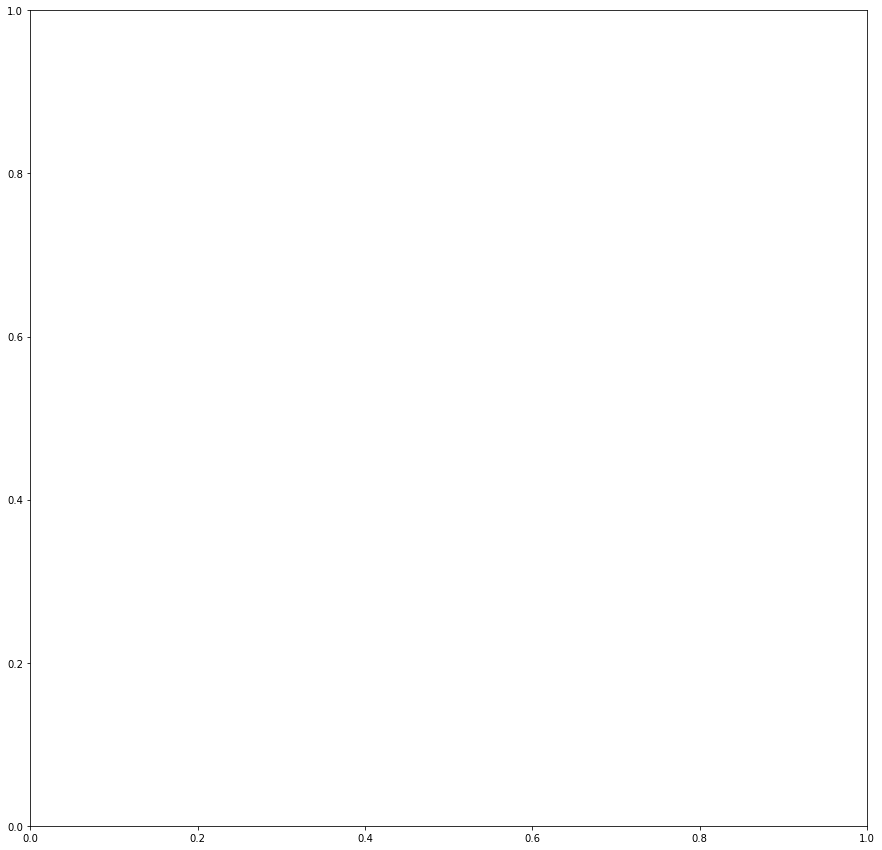

In [104]:
%matplotlib inline

#the goal of this cell is to refine object coordinates from some initial guesses using either 2MASS or GAIA

#taking star coords from text file
star_coords = np.genfromtxt('hh711_star_coords.txt', dtype=str)
print(star_coords)

#setting up query
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
import astropy.units as u

result_table = []
for i in star_coords[:-2]: #picking stars, trying to eliminate one...
    ra, dec = i
    result_table.append(Simbad.query_region(SkyCoord(ra+dec, frame='icrs'), radius='0.05s'))
print(result_table)

#defining psfs for original images...

#finally, make psfs for each star and then we determine the resolution from the PSFs
#can be done by fitting a gaussian (or other kernel) and normalizing so integral of psf is 1

#follow https://photutils.readthedocs.io/en/stable/epsf.html

#now, locate spots on the images
from astropy.nddata import NDData
from astropy.table import Table
from astropy.wcs.utils import skycoord_to_pixel
from photutils.psf import extract_stars #use this to make star cutouts

# nddata = NDData(data=hdu_data_list[-1], wcs=WCS(hdu_header_list[-1]))   #here reformatting data from 1.64 micron HST image
nddata_list = [NDData(data=i, wcs=j) for i,j in zip(hdu_data_list, hdu_header_list) ]

#this was made complicated bc you cannot directly go from skycoord to Table
stars_list = []
for nddata in nddata_list:

    stars_tbl = Table(names=('x', 'y'))
    for i in range(len(result_table)):
        ra_dec_formatted = SkyCoord(result_table[i]['RA'][0] + ' ' + result_table[i]['DEC'][0], frame='icrs', unit=(u.hourangle, u.deg))
        pix = skycoord_to_pixel(ra_dec_formatted, WCS(hdu_header_list[i]))
        stars_tbl.add_row(pix)
    
    stars = extract_stars(nddata, stars_tbl, size=25) 
    stars_list.append(stars)

    
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 1
ncols = 1

file_start = ['conv_0301_oIreproject2', 'conv_hareproject_shifted_up5_left3', 'conv_672_sIIreproject', 'conv_126_aligned', 'conv_128_aligned', 'conv_164_aligned.fits', 'f_Fe', 'f_H']

for i in range(len(stars_list)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    ax = ax.ravel()

    for j in range(nrows*ncols):
        norm = simple_norm(stars_list[i][j], 'log', percent=99.)
        ax[j].imshow(stars_list[i][j], norm=norm, origin='lower', cmap='viridis')
    
    plt.tight_layout()
    plt.savefig('hh7_11_checks/psfcutouts_orig/'+file_start[i]+'_psfcutout_orig.png')
    plt.close()

#attempting and failing to make an effective psf fitter

#increase maxiters to smooth more and decrease oversampling to avoid issues 
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=1, maxiters=30, smoothing_kernel='quadratic', progress_bar=False)  

import scipy as sp
from scipy.signal import find_peaks, peak_widths

fwhm_list = []

for i in range(len(stars_list)):
    epsf, fitted_stars = epsf_builder(stars_list[i])  
    norm = simple_norm(epsf.data, 'log', percent=99.9)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.colorbar()
    plt.savefig('hh7_11_checks/EPSFs_orig/'+file_start[i]+'_EPSF_orig.png')
    plt.close()
    
        #https://photutils.readthedocs.io/en/stable/psf_matching.html could be inspiration
    #https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-12.pdf can see for more...

    #instead let's double check stackoverflow for now...seems complex
    #ultimately just trying epsf cross section, like in https://stackoverflow.com/questions/18920614/plot-cross-section-through-heat-map

    # Coordinates of the line we'd like to sample along
    line = [(0, 13.5), (50, 13.5)]

    # Convert the line to pixel/index coordinates
    x, y = np.arange(epsf.data.shape[0]), np.arange(epsf.data.shape[1])
    x_world, y_world = np.array(list(zip(*line)))
    col = epsf.data.shape[1] * (x_world - x.min()) / x.ptp()
    row = epsf.data.shape[0] * (y_world - y.min()) / y.ptp()

    # Interpolate the line at "num" points...
    num = 27
    row, col = [np.linspace(item[0], item[1], num) for item in [row, col]]

    # Plot...
    fig, axes = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
    fig.delaxes(axes[0,1])

    axes[1,0].pcolormesh(x, y, epsf.data)
    axes[1,0].plot(x_world, y_world, 'ro-')
    axes[1,0].plot(y_world, x_world, 'bo-')
    axes[1,0].axis('image')

    # Extract the values along the line, using cubic interpolation
    #horizontal cut
    cross_sec_hori = sp.ndimage.map_coordinates(epsf.data, np.vstack((row, col)))
    axes[0,0].scatter(np.arange(len(cross_sec_hori)), cross_sec_hori, color='r')
    f_hori = sp.interpolate.InterpolatedUnivariateSpline(np.arange(len(cross_sec_hori)), cross_sec_hori) #next, interpolate the psfs to get fwhm
    axes[0,0].plot(np.arange(len(cross_sec_hori)-1, step=0.01), f_hori(np.arange(len(cross_sec_hori)-1, step=0.01)), color='r')

    #vertical cut
    cross_sec_vert = sp.ndimage.map_coordinates(epsf.data, np.vstack((col, row)))
    axes[1,1].scatter(cross_sec_vert, np.arange(len(cross_sec_vert)), color='b')
    f_vert = sp.interpolate.InterpolatedUnivariateSpline(np.arange(len(cross_sec_vert)), cross_sec_vert) #next, interpolate the psfs to get fwhm
    axes[1,1].plot(f_vert(np.arange(len(cross_sec_vert)-1, step=0.01)), np.arange(len(cross_sec_vert)-1, step=0.01), color='b')
    
    #find all peaks
    peak_list_hori, _ = find_peaks(f_hori(np.arange(len(cross_sec_hori), step=0.01)))
    peak_list_vert, _ = find_peaks(f_vert(np.arange(len(cross_sec_vert), step=0.01)))
    
    #find largest peak, referring to ind of the list above
    peak_hori_ind = np.argmax([f_hori(np.arange(len(cross_sec_hori), step=0.01))[i] for i in peak_list_hori]) 
    peak_vert_ind = np.argmax([f_vert(np.arange(len(cross_sec_vert), step=0.01))[i] for i in peak_list_vert])
    
    #plotting to confirm peaks
    axes[0,0].scatter(np.arange(len(cross_sec_vert), step=0.01)[peak_list_hori[peak_hori_ind]], f_hori(np.arange(len(cross_sec_hori), step=0.01))[peak_list_hori[peak_hori_ind]], marker='*', color='gold', s=500)
    axes[1,1].scatter(f_vert(np.arange(len(cross_sec_vert), step=0.01))[peak_list_vert[peak_vert_ind]], np.arange(len(cross_sec_vert), step=0.01)[peak_list_vert[peak_vert_ind]], marker='*', color='gold', s=500)
   
    #use to find widths...also normalizing with the length of the array / step
    width_norm = len(cross_sec_hori) / 0.5
    width_hori = peak_widths(f_hori(np.arange(len(cross_sec_hori), step=0.01)), [peak_list_hori[peak_hori_ind]], rel_height=0.3)[0] / width_norm
    width_vert = peak_widths(f_vert(np.arange(len(cross_sec_vert), step=0.01)), [peak_list_vert[peak_vert_ind]], rel_height=0.3)[0] / width_norm
    
    fwhm_list.append((width_hori + width_vert)/2.)
    
    #plotting to show widths
    axes[0,0].axvspan(np.arange(len(cross_sec_vert), step=0.01)[peak_list_hori[peak_hori_ind]]-width_hori/2., \
                      np.arange(len(cross_sec_vert), step=0.01)[peak_list_hori[peak_hori_ind]]+width_hori/2.,\
                     ymax=0.5*f_hori(np.arange(len(cross_sec_hori), step=0.01))[peak_list_hori[peak_hori_ind]] / np.max(f_hori(np.arange(len(cross_sec_hori), step=0.01))), \
                        alpha=0.25, facecolor='g')
    
    axes[1,1].axhspan(np.arange(len(cross_sec_vert), step=0.01)[peak_list_vert[peak_vert_ind]]-width_vert/2., \
                      np.arange(len(cross_sec_vert), step=0.01)[peak_list_vert[peak_vert_ind]]+width_vert/2.,\
                        xmax=0.5*f_vert(np.arange(len(cross_sec_vert), step=0.01))[peak_list_vert[peak_vert_ind]]/np.max(f_vert(np.arange(len(cross_sec_vert), step=0.01))), \
                        alpha=0.25, facecolor='g')

    plt.savefig('hh7_11_checks/psf_profiles_orig/'+file_start[i]+'_EPSF_orig.png')
    plt.close()

In [ ]:

'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''

res_str = '656shifted_flam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
# resize = 60. #if trying to adjust size of gaussian convolution
D = 2.4 #/ resize #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

#format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
#do each with its own psf
hdu_conv_list = [im_conv(i, D, j, k, 'gauss') for i,j,k in zip(files_data, hdu_pixtorad_list, hdu_data_list)]

print('convolved!')

'''
onto converting units and regridding...
'''
#converting the convolved image to correct units and saving it so we can reproject it
#conversion needed for hubble case since units are not in terms of surface brightness
hdu_conv_scaled_list = []

#for each convolved image, we need to convert from e-/s to flambda units which are in erg/s/cm^2/Angstrom...multiply by bw to get rid of angstrom
#...also images are divided through by throughput, so multiplying by throughput
#and lastly dividing by the arcsec^2 to get the image in surface brightness units, to be used in regridding
for count, i in enumerate(hdu_conv_list):

    #a condition added since the background corrected images have units corrected?
    if  count > 2: #the background subtracted images
        hdu_conv_scaled_list.append(i) #/ hdu_pixtorad_list[count]**2. ) #note if doing regridding should also add in , regrid only takes surface brightness
    elif count <= 2:
        hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count])


# In[6]:
#need a wcs standard for regridding and plots, fits files...
w = WCS(hdu_header_list[-1]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
wcs_header = hdu_header_list[-1]
wcs_header['HISTORY'] = 'Image was convolved and regridded, units were converted only for 656, 672, and 631 images. Units are all flux in CGS (ergs/s/cm^2).'	#adding history keyword so we know what we did to this image

    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
file_start = 'conv_checks/selfconv_'+res_str+'_'
conv_path_list = [] #list of paths to the convolved images, can be useful...


for count, i in enumerate(hdu_header_list):
    #finding wcs for a given image
    w = WCS(i)
    wcs_header = w.to_header()

    #saving each file to some path, conv_path is the path to that file
    conv_path = fits_saver(hdu_conv_scaled_list[count], wcs_header, files_data[count], file_start)
    conv_path_list.append(conv_path)


In [ ]:

'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''

res_str = '656shifted_flam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
# resize = 60. #if trying to adjust size of gaussian convolution
D = 2.4 #/ resize #that of Hubble, in m
D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

#format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
#do each with its own psf

hdu_conv_list = [im_conv('164_dash', D, j, k, 'gauss') for j,k in zip(hdu_pixtorad_list, hdu_data_list)]


print('convolved!')

'''
onto converting units and regridding...
'''
#converting the convolved image to correct units and saving it so we can reproject it
#conversion needed for hubble case since units are not in terms of surface brightness
hdu_conv_scaled_list = []

#for each convolved image, we need to convert from e-/s to flambda units which are in erg/s/cm^2/Angstrom...multiply by bw to get rid of angstrom
#...also images are divided through by throughput, so multiplying by throughput
#and lastly dividing by the arcsec^2 to get the image in surface brightness units, to be used in regridding
for count, i in enumerate(hdu_conv_list):

    #a condition added since the background corrected images have units corrected?
    if  count > 2: #the background subtracted images
        hdu_conv_scaled_list.append(i) #/ hdu_pixtorad_list[count]**2. ) #note if doing regridding should also add in , regrid only takes surface brightness
    elif count <= 2:
        hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count])


# In[6]:
#need a wcs standard for regridding and plots, fits files...
w = WCS(hdu_header_list[-1]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
wcs_header = hdu_header_list[-1]
wcs_header['HISTORY'] = 'Image was convolved and regridded, units were converted only for 656, 672, and 631 images. Units are all flux in CGS (ergs/s/cm^2).'	#adding history keyword so we know what we did to this image

    #you'll need to set the WCS to be that of the header you're basing this off of...ie the header
file_start = 'conv_checks/164conv_'+res_str+'_'
conv_path_list = [] #list of paths to the convolved images, can be useful...


for count, i in enumerate(hdu_header_list):
    #finding wcs for a given image
    w = WCS(i)
    wcs_header = w.to_header()

    #saving each file to some path, conv_path is the path to that file
    conv_path = fits_saver(hdu_conv_scaled_list[count], wcs_header, files_data[count], file_start)
    conv_path_list.append(conv_path)
